# Word segmentation in child-directed speech

In this homework we will bring together, and extend, two things we have worked on before: (1) child-directed speech, and (2) phoneme transition probabilities. 

Specifically, we will explore phoneme transition probabilities as a possible cue for word segmentation in child-directed speech, following the reading by Hockema 2006.  

As in an earlier homework, we will rely on data from the Adam section of the Brown corpus in the [CHILDES dataset](https://childes.talkbank.org/).  We focus specifically on the last transcript, when Adam was oldest, to get relatively complex child-directed speech.  Hockema used all of the corpora in the US English portion of CHILDES, so we are examining a very small portion of the overall dataset he considered. 

As in a different earlier homework, we will rely on data from [Wikipron](https://github.com/kylebgorman/wikipron) to get phoneme-level representations of word pronunciations.  We use US English pronunciation, to match the child data from CHILDES.  

Please feel free, and even warmly invited, to extend this to any language for which you can find matching data in CHILDES and Wikipron!

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random

### Read in CHILDES data

This is mostly copy-and-paste from an earlier homework.  Use an XML parser, to avoid tears!  The one difference is that here we are interested in mother's speech only, not child's.

In [2]:
fname = 'data/adam-050212.xml' # last adam file

In [3]:
# read in and traverse the entire XML tree, pull out utterances, store in a pandas df, and keep only 
# utterances produced by the mother, i.e. MOT.
# that df will be called mdf, for mother df.

# YOUR CODE GOES HERE.

tree = ET.parse(fname)
root = tree.getroot()

d = {'Who': [], 'Utt': []}

th = "{http://www.talkbank.org/ns/talkbank}"   # th = tag header
for utt in root.iter(th+'u'):  # 'u' = tag for utterance
    who = utt.attrib['who']
    d['Who'].append(who)
    ll = []
    for word in utt.findall(th+'w'):
        if word.text != None:  # ignore null words, of which there are some
            ll.append(word.text)
    d['Utt'].append(ll)
    
mdf = pd.DataFrame(data = d)  # df with both child and mother's utt
mdf = mdf[mdf['Who'] == 'MOT']  # keep only mother's utt

# pd.set_option('display.max_rows', None)  # display all rows in the dataframe
# mdf  # sanity check

mdf.sample(n=25)

,Who,Utt
1430,MOT,"[that's, right]"
844,MOT,"[now, I'll, go, all, the, way, downstairs]"
846,MOT,"[you, go, back, in, there]"
960,MOT,"[what, d, you, think, it, is]"
1516,MOT,"[why, would, you, do, that]"
60,MOT,"[maybe, one, day]"
76,MOT,[no]
1564,MOT,"[you, hafta, be, careful]"
982,MOT,"[what, else, did, you, do, in, school, today]"
305,MOT,"[shall, we, make, something, with, these]"


### Read in word pronunciation data from WikiPron

Again, this is copy-and-paste from an earlier homework.

In [4]:
# read in english words.  pdf = pronunciation df.
fname = "data/eng_us_phonemic.tsv"

# YOUR CODE GOES HERE.
pdf = pd.read_csv(fname, sep='\t', names=['Word', 'Pron'])
pdf.Pron = pdf.Pron.str.split()  # turn space-separated strings into lists of phonemes

pdf.sample(n=25)

,Word,Pron
26241,intersection,"[ɪ, n, t, ə, ɹ, s, ɛ, k, ʃ, ə, n]"
38489,product,"[p, ɹ, ɑ, d, ə, k, t]"
51305,waftage,"[w, ɒ, f, t, ɪ, d, ʒ]"
42941,semis,"[s, ɛ, m, iː, z]"
18260,excoriate,"[ɪ, k, s, k, ɔ, ɹ, i, e, ɪ, t]"
38975,puffin,"[p, ʌ, f, ɪ, n]"
13279,crouchings,"[k, ɹ, a, ʊ, t, ʃ, ɪ, ŋ, z]"
27502,kerberos,"[k, ɜ, ɹ, b, ə, ɹ, ə, s]"
16472,e.g.,"[i, d, ʒ, i]"
30806,mayfield,"[m, e, ɪ, f, i, l, d]"


In [5]:
# now create a dict called pron, s.t. pron[word] yields the pronunciation of that word in phonemes.

# YOUR CODE GOES HERE.

pron = {}

for i in range(len(pdf)):
    pron[pdf.iloc[i].Word] = pdf.iloc[i].Pron


print(pron['big'])
print(pron['drum'])
if 'you' in pron:
    print(pron['you'])
if 'i' in pron:
    print(pron['i'])

['b', 'ɪ', 'ɡ']
['d', 'ɹ', 'ʌ', 'm']
['ɪ']


# Replicate Hockema's central finding

Hockema's central finding is illustrated in his Figure 2: US English phoneme transition pairs, or PTPs are strongly bimodally distributed in child-directed speech, such that most are either almost certain to cross a word boundary, or almost certain not to - suggesting that PTPs can in principle be used as a cue to word segmentation.

We want to replicate that finding.  Here's what is needed to do that, beyond what we already have:

- Retain word boundaries but merge all utterances together into one long list.
- Explode each word in that list into phonemes, e.g.: "big" $\rightarrow$ ['b', 'ɪ', 'ɡ'].
- Determine which phonemes are in the corpus.
- Determine the set of all possible phoneme transition pairs, or PTPs.
- Determine p(word boundary|ptp) for each ptp, or phoneme transition pair.
- Plot histogram.

In [6]:
# retain word boundaries but merge all utterances together into one long list, called corpus.

# YOUR CODE GOES HERE.
corpus = [j for i in range(len(mdf)) for j in mdf.Utt.iloc[i]] # REPLACE

print("corpus is", len(corpus), "words long.")
corpus

corpus is 1230 words long.


['you',
 'say',
 'no',
 'why',
 'not',
 'why',
 'not',
 "I'm",
 'going',
 'upstairs',
 'and',
 'check',
 'on',
 'you',
 'have',
 'a',
 'car',
 'in',
 'the',
 'back',
 'yard',
 'what',
 'does',
 'it',
 'play',
 'or',
 'sing',
 'it',
 'can',
 'sing',
 'to',
 'make',
 'jingle',
 'bells',
 'try',
 'it',
 'again',
 'use',
 'your',
 'finger',
 'oh',
 'did',
 'you',
 'tell',
 'Ursula',
 'about',
 'your',
 'school',
 'maybe',
 'one',
 'day',
 'when',
 "you're",
 'a',
 'little',
 'older',
 'and',
 'a',
 'little',
 'bigger',
 'David',
 'is',
 'eleven',
 'now',
 'no',
 'I',
 'think',
 'so',
 'whatever',
 "you'd",
 'like',
 'to',
 'play',
 'Old_Mac_Donald',
 'he',
 'says',
 "he'd",
 'sharpen',
 'scissors',
 'and',
 'knives',
 'and',
 'gives',
 'you',
 'a',
 "year's",
 'guarantee',
 'for',
 'the',
 'sound',
 'maybe',
 'the',
 'hole',
 'is',
 'for',
 'the',
 'sound',
 'to',
 'come',
 'out',
 'do',
 'you',
 'think',
 "you're",
 'finished',
 'with',
 'the',
 'banjo',
 'you',
 "don't",
 'like',
 'those

In [7]:
# explode each word into phonemes.  
# simply drop words that are not in the pron dict.
# and add the pseudo-phoneme '*' after each word to mark word boundaries
# ec = exploded corpus

# YOUR CODE GOES HERE.
ec = [p for word in corpus if word in pron.keys() for p in pron[word]+['*']]  # REPLACE

print("exploded corpus is", len(ec), "phonemes long, including word boundaries.")
ec

exploded corpus is 4270 phonemes long, including word boundaries.


['s',
 'e',
 'ɪ',
 '*',
 'ʍ',
 'a',
 'ɪ',
 '*',
 'n',
 'ɒ',
 't',
 '*',
 'ʍ',
 'a',
 'ɪ',
 '*',
 'n',
 'ɒ',
 't',
 '*',
 'ɡ',
 'ɔ',
 'ɪ',
 'ŋ',
 '*',
 'ʌ',
 'p',
 's',
 't',
 'ɛ',
 'ɹ',
 'z',
 '*',
 't͡ʃ',
 'ɛ',
 'k',
 '*',
 'ə',
 '*',
 'k',
 'ɑ',
 'ɹ',
 '*',
 'ɪ',
 'n',
 '*',
 'ð',
 'iː',
 '*',
 'b',
 'æ',
 'k',
 '*',
 'j',
 'ɑ',
 'ɹ',
 'd',
 '*',
 'ʍ',
 'ʌ',
 't',
 '*',
 'd',
 'o',
 'ʊ',
 'z',
 '*',
 'ɪ',
 't',
 '*',
 'p',
 'l',
 'e',
 'ɪ',
 '*',
 'ɚ',
 '*',
 's',
 'ɪ',
 'ŋ',
 '*',
 'ɪ',
 't',
 '*',
 'k',
 'ə',
 'n',
 '*',
 's',
 'ɪ',
 'ŋ',
 '*',
 't',
 'ʊ',
 '*',
 'm',
 'e',
 'ɪ',
 'k',
 '*',
 'd',
 'ʒ',
 'ɪ',
 'ŋ',
 'ɡ',
 'ə',
 'l',
 '*',
 'b',
 'ɛ',
 'l',
 'z',
 '*',
 't',
 'ɹ',
 'a',
 'ɪ',
 '*',
 'ɪ',
 't',
 '*',
 'ə',
 'ɡ',
 'ɛ',
 'n',
 '*',
 'j',
 'uː',
 's',
 '*',
 'j',
 'ʊ',
 'ə',
 'ɹ',
 '*',
 'f',
 'ɪ',
 'ŋ',
 'ɡ',
 'ɚ',
 '*',
 'o',
 'ʊ',
 '*',
 'd',
 'ɪ',
 'd',
 '*',
 't',
 'ɛ',
 'ɫ',
 '*',
 'ə',
 'b',
 'a',
 'ʊ',
 't',
 '*',
 'j',
 'ʊ',
 'ə',
 'ɹ',
 '*',
 's',
 'k',
 'uː',

In [8]:
# determine the set of all phonemes in the corpus.
# but do not include the pseudo-phoneme '*'.

# YOUR CODE GOES HERE.
phonemes = set([i for i in ec if i != '*'])  # REPLACE

print(len(phonemes))
print(phonemes)

51
{'t͡ʃ', 'iː', 'b', 'o', 'ʊ', 'ð', 'm', 'ʌ', 'k', 'w', 'θ', 'a', 'ʍ', 'ɒ', 'ɔ', 'ɑ', 'e', 'ʒ', 'v', 'ɜ', 'i', 't', 'd͡ʒ', 'l', 'ɑː', 'ɡ', 'ɫ', 'ə', 'ŋ', 'j', 's', 'u', 'l̩', 'f', 'ɝː', 'uː', 'ɪ', 'ɝ', 'ʃ', 'p', 'n̩', 'n', 'z', 'ɨ', 'ɹ', 'd', 'ɔː', 'ɛ', 'h', 'æ', 'ɚ'}


In [9]:
# create a list of all possible phoneme transition pairs, or PTPs.

# YOUR CODE GOES HERE.
ptps = [(i, j) for i in phonemes for j in phonemes]  # REPLACE

print(len(ptps))
print(ptps)

2601
[('t͡ʃ', 't͡ʃ'), ('t͡ʃ', 'iː'), ('t͡ʃ', 'b'), ('t͡ʃ', 'o'), ('t͡ʃ', 'ʊ'), ('t͡ʃ', 'ð'), ('t͡ʃ', 'm'), ('t͡ʃ', 'ʌ'), ('t͡ʃ', 'k'), ('t͡ʃ', 'w'), ('t͡ʃ', 'θ'), ('t͡ʃ', 'a'), ('t͡ʃ', 'ʍ'), ('t͡ʃ', 'ɒ'), ('t͡ʃ', 'ɔ'), ('t͡ʃ', 'ɑ'), ('t͡ʃ', 'e'), ('t͡ʃ', 'ʒ'), ('t͡ʃ', 'v'), ('t͡ʃ', 'ɜ'), ('t͡ʃ', 'i'), ('t͡ʃ', 't'), ('t͡ʃ', 'd͡ʒ'), ('t͡ʃ', 'l'), ('t͡ʃ', 'ɑː'), ('t͡ʃ', 'ɡ'), ('t͡ʃ', 'ɫ'), ('t͡ʃ', 'ə'), ('t͡ʃ', 'ŋ'), ('t͡ʃ', 'j'), ('t͡ʃ', 's'), ('t͡ʃ', 'u'), ('t͡ʃ', 'l̩'), ('t͡ʃ', 'f'), ('t͡ʃ', 'ɝː'), ('t͡ʃ', 'uː'), ('t͡ʃ', 'ɪ'), ('t͡ʃ', 'ɝ'), ('t͡ʃ', 'ʃ'), ('t͡ʃ', 'p'), ('t͡ʃ', 'n̩'), ('t͡ʃ', 'n'), ('t͡ʃ', 'z'), ('t͡ʃ', 'ɨ'), ('t͡ʃ', 'ɹ'), ('t͡ʃ', 'd'), ('t͡ʃ', 'ɔː'), ('t͡ʃ', 'ɛ'), ('t͡ʃ', 'h'), ('t͡ʃ', 'æ'), ('t͡ʃ', 'ɚ'), ('iː', 't͡ʃ'), ('iː', 'iː'), ('iː', 'b'), ('iː', 'o'), ('iː', 'ʊ'), ('iː', 'ð'), ('iː', 'm'), ('iː', 'ʌ'), ('iː', 'k'), ('iː', 'w'), ('iː', 'θ'), ('iː', 'a'), ('iː', 'ʍ'), ('iː', 'ɒ'), ('iː', 'ɔ'), ('iː', 'ɑ'), ('iː', 'e'), ('iː', 'ʒ'), ('iː', 'v'), ('iː', 'ɜ'), ('iː',

### What quantity do we want?

For each phoneme transition pair or PTP, we want the probability of a word boundary given that PTP, i.e. we want $p($word boundary$ | $PTP$_i), \forall i$.  This is the probability that a word boundary intervenes between the two phonemes of the pair.  We will use those quantities to create a histogram, with probability of a word boundary on the x-axis, while the y-axis denotes the percentage of PTPs that have that probability of a word boundary, binned.

The conditional probability of a word boundary given a particular PTP can be calculated as a simple relative frequency:

\begin{equation}
p(\text{word boundary} | \text{PTP}_i) = \frac{c(\text{word boundary} \land \text{PTP}_i)}{c(\text{PTP}_i)}
\end{equation}

where $c(\cdot)$ stands for count, and measures counts in the corpus.

In [10]:
# start with the numerator of the above eqn: count the number of times each PTP in the corpus
# crosses a word boundary.
# we start by creating a dict ptp_across_counts. 
# the key is a pair (p1,p2), and the value is the count for that pair crossing a word boundary.
# we initialize all PTP counts to 0.

# YOUR CODE GOES HERE.
ptp_across_count = {ptp: 0 for ptp in ptps}   # REPLACE

ptp_across_count

{('t͡ʃ', 't͡ʃ'): 0,
 ('t͡ʃ', 'iː'): 0,
 ('t͡ʃ', 'b'): 0,
 ('t͡ʃ', 'o'): 0,
 ('t͡ʃ', 'ʊ'): 0,
 ('t͡ʃ', 'ð'): 0,
 ('t͡ʃ', 'm'): 0,
 ('t͡ʃ', 'ʌ'): 0,
 ('t͡ʃ', 'k'): 0,
 ('t͡ʃ', 'w'): 0,
 ('t͡ʃ', 'θ'): 0,
 ('t͡ʃ', 'a'): 0,
 ('t͡ʃ', 'ʍ'): 0,
 ('t͡ʃ', 'ɒ'): 0,
 ('t͡ʃ', 'ɔ'): 0,
 ('t͡ʃ', 'ɑ'): 0,
 ('t͡ʃ', 'e'): 0,
 ('t͡ʃ', 'ʒ'): 0,
 ('t͡ʃ', 'v'): 0,
 ('t͡ʃ', 'ɜ'): 0,
 ('t͡ʃ', 'i'): 0,
 ('t͡ʃ', 't'): 0,
 ('t͡ʃ', 'd͡ʒ'): 0,
 ('t͡ʃ', 'l'): 0,
 ('t͡ʃ', 'ɑː'): 0,
 ('t͡ʃ', 'ɡ'): 0,
 ('t͡ʃ', 'ɫ'): 0,
 ('t͡ʃ', 'ə'): 0,
 ('t͡ʃ', 'ŋ'): 0,
 ('t͡ʃ', 'j'): 0,
 ('t͡ʃ', 's'): 0,
 ('t͡ʃ', 'u'): 0,
 ('t͡ʃ', 'l̩'): 0,
 ('t͡ʃ', 'f'): 0,
 ('t͡ʃ', 'ɝː'): 0,
 ('t͡ʃ', 'uː'): 0,
 ('t͡ʃ', 'ɪ'): 0,
 ('t͡ʃ', 'ɝ'): 0,
 ('t͡ʃ', 'ʃ'): 0,
 ('t͡ʃ', 'p'): 0,
 ('t͡ʃ', 'n̩'): 0,
 ('t͡ʃ', 'n'): 0,
 ('t͡ʃ', 'z'): 0,
 ('t͡ʃ', 'ɨ'): 0,
 ('t͡ʃ', 'ɹ'): 0,
 ('t͡ʃ', 'd'): 0,
 ('t͡ʃ', 'ɔː'): 0,
 ('t͡ʃ', 'ɛ'): 0,
 ('t͡ʃ', 'h'): 0,
 ('t͡ʃ', 'æ'): 0,
 ('t͡ʃ', 'ɚ'): 0,
 ('iː', 't͡ʃ'): 0,
 ('iː', 'iː'): 0,
 ('iː', 'b'): 0,
 ('iː', 'o'): 0,


In [11]:
# now slide a width-3 window through the corpus, and increment the (p1,p2) count for every (p1,p2) 
# phoneme pair you encounter, provided a word boundary ('*') appears between them.

# YOUR CODE GOES HERE.
for i in range(len(ec) - 2):
    window = ec[i: (i+3)]
    if window[1] == '*':
         ptp_across_count[(window[0], window[2])] += 1

ptp_across_count

{('t͡ʃ', 't͡ʃ'): 0,
 ('t͡ʃ', 'iː'): 0,
 ('t͡ʃ', 'b'): 0,
 ('t͡ʃ', 'o'): 0,
 ('t͡ʃ', 'ʊ'): 0,
 ('t͡ʃ', 'ð'): 0,
 ('t͡ʃ', 'm'): 0,
 ('t͡ʃ', 'ʌ'): 0,
 ('t͡ʃ', 'k'): 0,
 ('t͡ʃ', 'w'): 0,
 ('t͡ʃ', 'θ'): 0,
 ('t͡ʃ', 'a'): 0,
 ('t͡ʃ', 'ʍ'): 0,
 ('t͡ʃ', 'ɒ'): 0,
 ('t͡ʃ', 'ɔ'): 0,
 ('t͡ʃ', 'ɑ'): 0,
 ('t͡ʃ', 'e'): 0,
 ('t͡ʃ', 'ʒ'): 0,
 ('t͡ʃ', 'v'): 0,
 ('t͡ʃ', 'ɜ'): 0,
 ('t͡ʃ', 'i'): 0,
 ('t͡ʃ', 't'): 0,
 ('t͡ʃ', 'd͡ʒ'): 0,
 ('t͡ʃ', 'l'): 0,
 ('t͡ʃ', 'ɑː'): 0,
 ('t͡ʃ', 'ɡ'): 0,
 ('t͡ʃ', 'ɫ'): 0,
 ('t͡ʃ', 'ə'): 0,
 ('t͡ʃ', 'ŋ'): 0,
 ('t͡ʃ', 'j'): 0,
 ('t͡ʃ', 's'): 0,
 ('t͡ʃ', 'u'): 0,
 ('t͡ʃ', 'l̩'): 0,
 ('t͡ʃ', 'f'): 0,
 ('t͡ʃ', 'ɝː'): 0,
 ('t͡ʃ', 'uː'): 0,
 ('t͡ʃ', 'ɪ'): 0,
 ('t͡ʃ', 'ɝ'): 0,
 ('t͡ʃ', 'ʃ'): 0,
 ('t͡ʃ', 'p'): 0,
 ('t͡ʃ', 'n̩'): 0,
 ('t͡ʃ', 'n'): 0,
 ('t͡ʃ', 'z'): 0,
 ('t͡ʃ', 'ɨ'): 0,
 ('t͡ʃ', 'ɹ'): 0,
 ('t͡ʃ', 'd'): 0,
 ('t͡ʃ', 'ɔː'): 0,
 ('t͡ʃ', 'ɛ'): 0,
 ('t͡ʃ', 'h'): 0,
 ('t͡ʃ', 'æ'): 0,
 ('t͡ʃ', 'ɚ'): 0,
 ('iː', 't͡ʃ'): 0,
 ('iː', 'iː'): 0,
 ('iː', 'b'): 12,
 ('iː', 'o'): 0,

In [12]:
# now do the same thing for within-word occurrences of (p1,p2).
# start by creating dict ptp_within_count and initializing all ptps to 0.

# YOUR CODE GOES HERE.
ptp_within_count = {ptp: 0 for ptp in ptps} # REPLACE

# now slide a width-2 window through the corpus, and increment the (p1,p2) count for every (p1,p2) 
# phoneme pair you encounter, directly adjacent to each other.  this is without phoneme boundaries.

# YOUR CODE GOES HERE.
for i in range(len(ec) - 1):
    window = ec[i: (i+2)]
    if '*' not in window:
         ptp_within_count[(window[0], window[1])] += 1

ptp_within_count

{('t͡ʃ', 't͡ʃ'): 0,
 ('t͡ʃ', 'iː'): 0,
 ('t͡ʃ', 'b'): 0,
 ('t͡ʃ', 'o'): 0,
 ('t͡ʃ', 'ʊ'): 0,
 ('t͡ʃ', 'ð'): 0,
 ('t͡ʃ', 'm'): 0,
 ('t͡ʃ', 'ʌ'): 0,
 ('t͡ʃ', 'k'): 0,
 ('t͡ʃ', 'w'): 0,
 ('t͡ʃ', 'θ'): 0,
 ('t͡ʃ', 'a'): 0,
 ('t͡ʃ', 'ʍ'): 0,
 ('t͡ʃ', 'ɒ'): 0,
 ('t͡ʃ', 'ɔ'): 0,
 ('t͡ʃ', 'ɑ'): 0,
 ('t͡ʃ', 'e'): 0,
 ('t͡ʃ', 'ʒ'): 0,
 ('t͡ʃ', 'v'): 0,
 ('t͡ʃ', 'ɜ'): 0,
 ('t͡ʃ', 'i'): 0,
 ('t͡ʃ', 't'): 0,
 ('t͡ʃ', 'd͡ʒ'): 0,
 ('t͡ʃ', 'l'): 0,
 ('t͡ʃ', 'ɑː'): 0,
 ('t͡ʃ', 'ɡ'): 0,
 ('t͡ʃ', 'ɫ'): 0,
 ('t͡ʃ', 'ə'): 0,
 ('t͡ʃ', 'ŋ'): 0,
 ('t͡ʃ', 'j'): 0,
 ('t͡ʃ', 's'): 0,
 ('t͡ʃ', 'u'): 0,
 ('t͡ʃ', 'l̩'): 0,
 ('t͡ʃ', 'f'): 0,
 ('t͡ʃ', 'ɝː'): 0,
 ('t͡ʃ', 'uː'): 0,
 ('t͡ʃ', 'ɪ'): 0,
 ('t͡ʃ', 'ɝ'): 0,
 ('t͡ʃ', 'ʃ'): 0,
 ('t͡ʃ', 'p'): 0,
 ('t͡ʃ', 'n̩'): 0,
 ('t͡ʃ', 'n'): 0,
 ('t͡ʃ', 'z'): 0,
 ('t͡ʃ', 'ɨ'): 0,
 ('t͡ʃ', 'ɹ'): 0,
 ('t͡ʃ', 'd'): 0,
 ('t͡ʃ', 'ɔː'): 0,
 ('t͡ʃ', 'ɛ'): 1,
 ('t͡ʃ', 'h'): 0,
 ('t͡ʃ', 'æ'): 0,
 ('t͡ʃ', 'ɚ'): 1,
 ('iː', 't͡ʃ'): 0,
 ('iː', 'iː'): 0,
 ('iː', 'b'): 0,
 ('iː', 'o'): 0,


In [13]:
# create a dict pwb = prob word boundary, that holds, for each ptp, the prob(word boundary | ptp).
# key = ptp, value = prob.
# value is obtained as ptp_across_count[ptp] / (ptp_across_count[ptp] + ptp_within_count[ptp])
# NB: for some PTPs all values could be 0 - we will collect these in a list called unused.
# then only compute probs for PTPs that were used, i.e. are not in list unused.

# YOUR CODE GOES HERE.
unused = [ptp for ptp in ptps if ptp_across_count[ptp] == 0 and ptp_within_count[ptp] == 0]  # REPLACE
#pwb = {ptp: ptp_across_count[ptp] / (ptp_across_count[ptp] + ptp_within_count[ptp]) for ptp in ptps if ptp not in un}  # REPLACE
# TR: i commented out the above line and applied un -> unused:
pwb = {ptp: ptp_across_count[ptp] / (ptp_across_count[ptp] + ptp_within_count[ptp]) for ptp in ptps if ptp not in unused}  # REPLACE


print(len(ptps), len(unused), len(pwb))
pwb

2601 1985 616


{('t͡ʃ', 'ɛ'): 0.0,
 ('t͡ʃ', 'ɚ'): 0.0,
 ('iː', 'b'): 1.0,
 ('iː', 'm'): 1.0,
 ('iː', 'ʌ'): 1.0,
 ('iː', 'w'): 1.0,
 ('iː', 'θ'): 1.0,
 ('iː', 'ʍ'): 1.0,
 ('iː', 't'): 0.6,
 ('iː', 'ə'): 1.0,
 ('iː', 'j'): 1.0,
 ('iː', 's'): 0.75,
 ('iː', 'f'): 1.0,
 ('iː', 'p'): 0.6666666666666666,
 ('iː', 'n'): 0.25,
 ('iː', 'z'): 0.0,
 ('iː', 'ɹ'): 1.0,
 ('iː', 'd'): 0.0,
 ('iː', 'h'): 1.0,
 ('b', 'ʌ'): 0.0,
 ('b', 'a'): 0.0,
 ('b', 'ɒ'): 0.0,
 ('b', 'ɔ'): 0.0,
 ('b', 'ɑ'): 0.0,
 ('b', 'i'): 0.0,
 ('b', 'l'): 0.0,
 ('b', 'ə'): 0.0,
 ('b', 'ɪ'): 0.0,
 ('b', 'ɹ'): 0.0,
 ('b', 'ɔː'): 0.0,
 ('b', 'ɛ'): 0.0,
 ('b', 'æ'): 0.0,
 ('b', 'ɚ'): 0.0,
 ('o', 'ʊ'): 0.0,
 ('ʊ', 'b'): 1.0,
 ('ʊ', 'o'): 1.0,
 ('ʊ', 'ð'): 1.0,
 ('ʊ', 'm'): 1.0,
 ('ʊ', 'k'): 0.47058823529411764,
 ('ʊ', 'w'): 1.0,
 ('ʊ', 'θ'): 0.5,
 ('ʊ', 'a'): 1.0,
 ('ʊ', 'ʍ'): 1.0,
 ('ʊ', 'ɔ'): 1.0,
 ('ʊ', 'v'): 0.0,
 ('ʊ', 't'): 0.4,
 ('ʊ', 'd͡ʒ'): 1.0,
 ('ʊ', 'l'): 0.3333333333333333,
 ('ʊ', 'ɡ'): 1.0,
 ('ʊ', 'ə'): 0.07692307692307693,
 ('ʊ', 'j'):

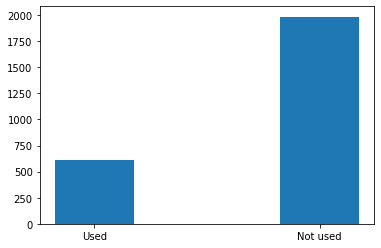

In [14]:
# plot used vs. not used.
N = 2   # number of bars
ind = np.arange(N)    # the x locations for the bars, evenly spaced
width = 0.35   # width of bars
plt.bar(ind, [len(pwb), len(unused)], width)
plt.xticks(ind, ('Used', 'Not used'))
plt.show()

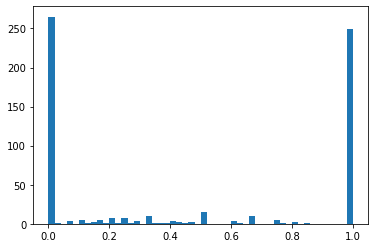

In [15]:
plt.hist(pwb.values(), bins=50)
plt.show()

In [16]:
# find the PTPs that are always within-word, and print out some.

# YOUR CODE GOES HERE.
within = [ptp for ptp in ptps if ptp_across_count[ptp] == 0 and ptp_within_count[ptp] != 0]  # REPLACE
print(len(within), "PTPs are used only within words.  Here are some:")
print(random.sample(within, 20))

# now find the PTPs that are always between-word, and print out some.

# YOUR CODE GOES HERE.
between = [ptp for ptp in ptps if ptp_across_count[ptp] != 0 and ptp_within_count[ptp] == 0]  # REPLACE
print(len(between), "PTPs are used only between words.  Here are some:")
print(random.sample(between, 20))

265 PTPs are used only within words.  Here are some:
[('iː', 'z'), ('w', 'ʌ'), ('d', 'e'), ('l', 'æ'), ('t͡ʃ', 'ɚ'), ('θ', 'ɹ'), ('l', 'z'), ('uː', 'z'), ('s', 'ɔ'), ('t', 'e'), ('h', 'æ'), ('ə', 'ʊ'), ('w', 'ʊ'), ('ɚ', 'l'), ('h', 'o'), ('b', 'ɚ'), ('θ', 'ɝ'), ('l', 'uː'), ('ɹ', 'iː'), ('ʌ', 'z')]
249 PTPs are used only between words.  Here are some:
[('t', 'ɡ'), ('ŋ', 't'), ('s', 'ð'), ('u', 'j'), ('l', 'b'), ('i', 'ɹ'), ('ŋ', 'd'), ('t', 'b'), ('d', 'd'), ('p', 'ʍ'), ('z', 'ɡ'), ('ʊ', 'b'), ('z', 'p'), ('ʊ', 's'), ('iː', 'ə'), ('t', 'j'), ('ʊ', 'ð'), ('iː', 'j'), ('ɹ', 'w'), ('ə', 'θ')]


# Observations and conclusions

- Write your general observations about the results here, and conclusions you can draw from them.  A short paragraph would be fine, but please separately specify observations and conclusions.

**Answer:**

General observations: Among all the possible pairs of phonemes in the corpus, only around 1/4 of them are actually used; among those that are actually used, most of them either only appear within a word or only appear across word boundaries (the two categories are similar in number as well, both around 250), very few of them appear at both positions.

Conclusions: Hockema (2006)'s results are replicated. Most English phoneme pairs examined can indeed be associated with a unique label of either "appears within a word" or "appears between words." Thus, it is theoretically possible that phoneme transition information can be used to detect word segmentation in English speech perception. However, apart from the problem of supervised learning, there is also the problem of generalizability: 

(1) It is probable that the result does not generalize to languages where most syllables (including at the end of words) begin with a consonant and end with a vowel, such as Italian; or more generally, to languages where most syllables are likely to appear at any place in a word, be it at the begnning, middle, or end, such as Chinese. Table 3 in Hockema's paper has shown that the top 10 interword transitions are all consonant-consonant pairs that sound weird when appearing in the middle of an English word; this is not the case for the two types of langauges (though there may be overlap) mentioned before.

(2) It is also probable that the result does not generalize to langauges where word segmentation itself, even in written format, can sometimes be ambiguous and needs scaffolding from syntactic or other contextual information, such as Chinese. E.g., while "根据地形(according to topography)" is considered a phrase comprising of two words "根据(according to)" and "地形(topography)," "根据地(base camp)" is a single word that cannot be further segmented. There are numerous examples like this in everyday Chinese; again, this is also related to point (1), the flexibility of a syllable being at any position in a word, since this is exactly the way how Chinese words are formed -- picking single-syllable-characters with relevant meanings and joining them together. 

# Extensions (optional)

- Do the same thing for **another language** that is represented in both CHILDES and Wikipron!  If the cue works only holds for English, it is of limited interest.  
- Consider utterance boundaries.  As we discussed in class, this analysis can be seen as an instance of **supervised learning**, in that we know the right answers, i.e. we know where the word boundaries are, and we are adjusting parameters (probabilities) to accommodate those right answers.  But the child does not have this information - instead, the child must **infer** word boundaries from the information available.  One approach we considered was to note that although word boundaries are not clear, utterance boundaries are - and utterance boundaries are word boundaries.  Does this give the child enough information to actually segment speech, using the ideas we have explored here?  Find out!